# Taller #3 - Agustín Vallejo - Radioastronomía

In [2]:
import numpy as np
import pylab as plt

In [5]:
deg = (np.pi/180)

In [6]:
# Parámetros de Observación
L = 34.0790*deg # ° - Latitud del Observador
dec = 34*deg # ° - Declinación del "Can Mayor" que se va a observar
freq = 1420e6 # Hz - Frecuencia de Observación
lam  = 299792458 / freq # m - Longitud de Onda de Observación

In [7]:
def base(ant1,ant2):
    """
    Para dos antenas, se calcula tanto el Baseline, como el Acimut y la Elevación
    """
    b_ENU = ant2-ant1
    D = np.linalg.norm(b_ENU)
    A=np.arctan2(b_ENU[0],b_ENU[1])
    E=0
    return (D,A,E) # Magnitud del Baseline, Acimut, y Elevación

![holi](eks.png)

In [8]:
def cosa(D,A,E,L,H,dec,lam):
    """
    Esta función toma los parámetros de Baseline y de Observación y calcula puntos en el espacio UVW
    """
    XYZ = abs(D) * np.array([np.cos(L)*np.sin(E) - np.sin(L)*np.cos(E)*np.cos(A),
                             np.sin(A)*np.cos(E),
                             np.sin(L)*np.sin(E) + np.cos(L)*np.cos(E)*np.cos(A)])
    
    xyz_uvw = np.array([[np.sin(H),np.cos(H),0],
                        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec)],
                        [+np.cos(dec)*np.cos(H),-np.cos(dec)*np.sin(H), np.sin(dec)]])

    UVW = (1/lam) * np.matmul(xyz_uvw,XYZ)
    return UVW # Retorna un vector UVW

In [9]:
antenas = np.loadtxt("vlaa.txt") # Se carga el archivo de Antenas

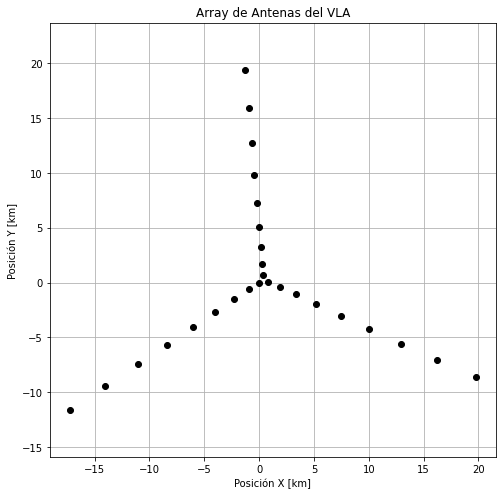

In [12]:
plt.figure(figsize=(8,8))
plt.axis("equal")
plt.plot(antenas[:,0]*1e-3,antenas[:,1]*1e-3,'ko')
plt.title("Array de Antenas del VLA")
plt.xlabel("Posición X [km]")
plt.ylabel("Posición Y [km]")
plt.grid()

In [14]:
UVs = [] # Se genera la lista que contiene los baselines en el espacio UV

H = 0 # h - Ángulo Horario inicial
N = len(antenas)
for i in range(N):
    """
    Para cada antena, se calculan los baselines correspondientes
    con las antenas que le siguen en la lista. Además se añade el
    componente negativo.
    """
    j = i+1
    while j<N:
        ant1 = antenas[i]
        ant2 = antenas[j]
        uv_point = cosa(*base(ant1,ant2),L,H,dec,lam)
        UVs.append(list( uv_point))
        UVs.append(list(-uv_point))
        j += 1
        
UVs = np.array(UVs)
NN = len(UVs) # Número de Baselines

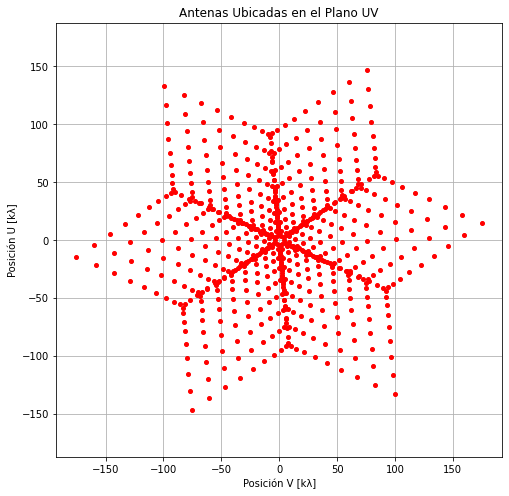

In [32]:
plt.figure(figsize=(8,8))
plt.axis("equal")
plt.plot(UVs[:,0]*1e-3,UVs[:,1]*1e-3,'ro',ms=4)
plt.title("Antenas Ubicadas en el Plano UV")
plt.xlabel("Posición V [kλ]")
plt.ylabel("Posición U [kλ]")
plt.grid()

In [16]:
time_steps = 600 # Puntos temporales
h = np.linspace(-4,4,time_steps)*np.pi/12  # rad - Ángulos Horarios en la ventana de observación 
UVs2 = np.zeros((time_steps,NN,3)) # Array vacío de baselines en el tiempo

for t in range(time_steps):
    """
    Para cada antena, en cada instante, se calculan los baselines 
    correspondientes con las antenas que le siguen en la lista. 
    Además se añade el componente negativo.
    """
    N = len(antenas)
    H = h[t]
    c = 0
    for i in range(N):
        j = i+1
        while j<N:
            ant1 = antenas[i]
            ant2 = antenas[j]
            UVs2[t,c] = list(cosa(*base(ant1,ant2),L,H,dec,lam))
            UVs2[t,c+1] = list(-cosa(*base(ant1,ant2),L,H,dec,lam))
            j += 1
            c += 2

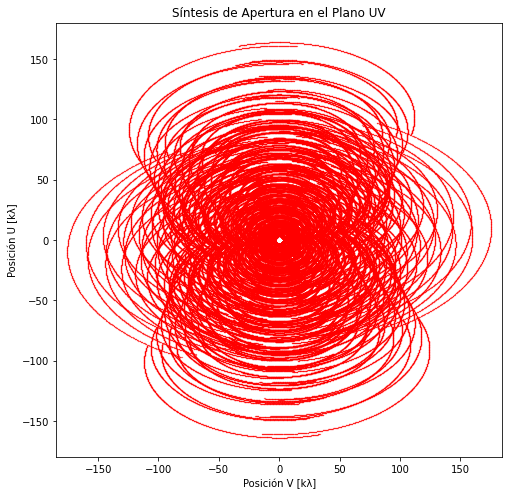

In [31]:
plt.figure(figsize=(8,8))
plt.axis("equal")
for x in range(NN):
    plt.plot(UVs2[:,x,0]*1e-3,UVs2[:,x,1]*1e-3,'r.',ms=0.5)
plt.title("Síntesis de Apertura en el Plano UV")
plt.xlabel("Posición V [kλ]")
plt.ylabel("Posición U [kλ]")
plt.show()

In [19]:
"""
El siguiente es un reordenamiento sencillo para tener un 
arreglo donde cada elemento sea una curva entera de la 
síntesis de apertura.
"""
UVs2reshape = np.reshape(UVs2,(time_steps*NN,3))

def minmax(array,axis):
    """
    Una función sencilla que me retorna los valores mínimos
    y máximos de la síntesis para saber los límites del reescalamiento.
    """
    return (min(array[:,axis]),max(array[:,axis]))

minX,maxX = minmax(UVs2reshape,0)
minY,maxY = minmax(UVs2reshape,1)

In [22]:
UVs2reshape_scale = UVs2reshape * 1000 / (maxX-minX) # Escalado para que esté entre -500 y 500.
print("Reescalados, los valores mínimo y máximo de V son: ",minmax(UVs2reshape_scale,0),"kms")
print("Reescalados, los valores mínimo y máximo de U son: ",minmax(UVs2reshape_scale,1),"kms")

Reescalados, los valores mínimo y máximo de V son:  (-500.00000000000006, 500.00000000000006) kms
Reescalados, los valores mínimo y máximo de U son:  (-466.36464972704744, 466.36464972704744) kms


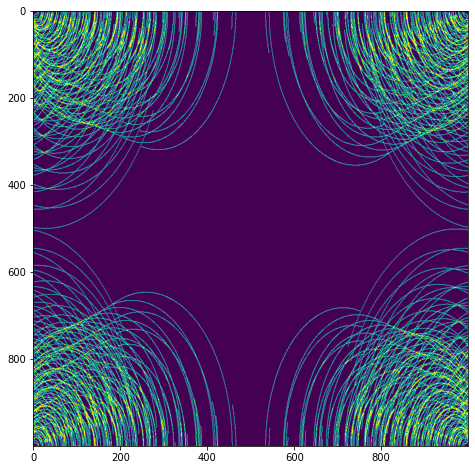

In [23]:
UVGrid = np.zeros((1000,1000))

for uv in UVs2reshape_scale:
    """
    Procedo a efectuar el grilleo.
    """
    i = int(uv[0])
    j = int(uv[1])
    UVGrid[i,j] = 1
    
plt.figure(figsize=(8,8))
plt.imshow(UVGrid)

In [28]:
#CARGANDO LA IMAGEN
xini = 0
yini = 100
im = plt.imread("Poker.JPG")[xini:1000+xini,yini:1000+yini,0] #Centro la imagen del Can Mayor y recorto un área gris de 1000x1000

In [29]:
imfft = np.fft.fft2(im) # Transformada de Fourier en 2D de la Imagen
construct = np.real(np.fft.ifft2(imfft*UVGrid)) # Parte real de la transformada inversa de imfft y el UVGrid

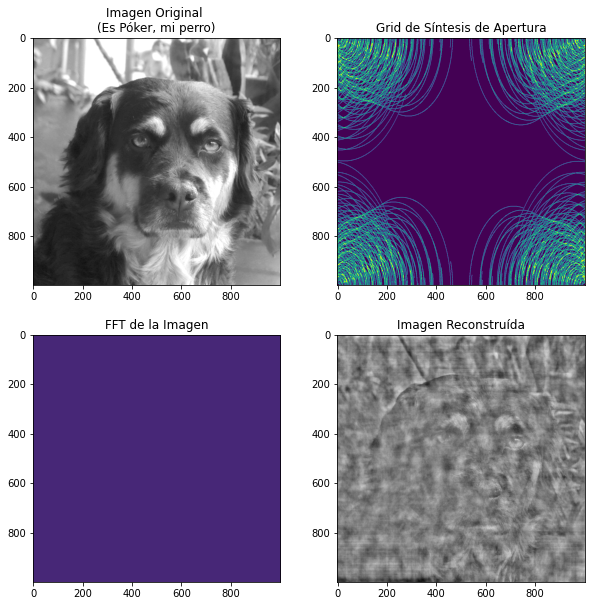

In [30]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Imagen Original \n(Es Póker, mi perro)")
plt.imshow(im,cmap='gray')
plt.subplot(2,2,2)
plt.title("Grid de Síntesis de Apertura")
plt.imshow(UVGrid)
plt.subplot(2,2,3)
plt.title("FFT de la Imagen")
plt.imshow(np.real(imfft))
plt.subplot(2,2,4)
plt.title("Imagen Reconstruída")
plt.imshow(construct,cmap='gray')

Como comentario: Le probé un montón a lo de FFT de la imagen y el imshow solo me muestra una imagen negra, entonces no sé qué debería ver ahí. Pero en la imagen reconstruída sí se alcanza a reconocer levemente algunos elementos de la original. Tampoco me quedó muy claro lo de poner los ejes de las imágenes en grados con la información que tenemos.